# Inspect UMAP of COI

The setup of this notebooks is to transform the data with UMAP and color the manifold according to labels and fluorescence intensity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, threads_per_worker=1)
client = Client(cluster)

In [5]:
reload(e_load)

<module 'ehv.load' from '/app/ehv/load.py'>

In [6]:
data_dd = e_load.load_raw_ideas_dir_dask(Path("/data/weizmann/EhV/high_time_res"), Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), "ALL", Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))
data_dd = data_dd.map_partitions(e_load.remove_unwanted_features)
data_dd = data_dd.map_partitions(e_load.tag_columns)
data_dd = data_dd.map_partitions(e_load.add_merged_col, cols=["meta_group", "meta_timepoint", "meta_replicate", "meta_Object Number"])

In [7]:
data_dd.head().filter(regex="meta_.*")

,meta_Object Number,meta_Time,meta_Flow Speed,meta_timepoint,meta_replicate,meta_group,meta_label_COI,meta_label_MCP_NEG_PSBA_POS,meta_label_MCP_POS_PSBA_POS,meta_label_MCP_POS_PSBA_NEG,meta_label_MCP_NEG_PSBA_NEG,meta_id
0,0,0.000000,43.123558,0,R1,Ctrl,False,False,False,False,False,Ctrl0R10
1,1,0.001988,43.147675,0,R1,Ctrl,False,False,False,False,False,Ctrl0R11
2,2,0.003687,43.147675,0,R1,Ctrl,False,False,False,False,False,Ctrl0R12
3,3,0.007776,43.147675,0,R1,Ctrl,False,False,False,False,False,Ctrl0R13
4,4,0.012374,43.147675,0,R1,Ctrl,False,False,False,False,False,Ctrl0R14


In [8]:
# filter out non-COI cells
data_dd = data_dd.map_partitions(lambda p: p[p["meta_label_COI"]==True])

In [9]:
data_dd = data_dd.repartition(npartitions=10)

In [10]:
data_dd = data_dd.persist()

# High samples (COI only)

In [11]:
def do_umap(data, **umap_args):
    projector = umap.UMAP(**umap_args)
    projection = projector.fit_transform(data.filter(regex="feat_.*"))
    projection = pandas.DataFrame(projection, columns=["dim_%d" % i for i in range(1, projector.get_params()["n_components"]+1)])
    return pandas.concat([data[["meta_id"]].reset_index(drop=True), projection], axis=1)

## Compute 2D projection

In [13]:
meta_df = data_dd[["meta_id"]].head(0)
meta_df["dim_1"] = 0.0
meta_df["dim_2"] = 0.0
meta_df.head()

,meta_id,dim_1,dim_2


In [19]:
%%time
projected = data_dd[data_dd["meta_group"] == "High"].groupby("meta_timepoint").apply(do_umap, n_components=2, meta=meta_df).compute()
projected = projected.reset_index(drop=True)

CPU times: user 1min 29s, sys: 4.79 s, total: 1min 34s
Wall time: 2min 57s


In [53]:
dump(projected, "data/umap/HTR_High_COI_pertp.dat")

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


['data/umap/HTR_High_COI_pertp.dat']

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


## Compute 1D projection

In [14]:
meta_df = data_dd[["meta_id"]].head(0)
meta_df["dim_1"] = 0.0
meta_df.head()

,meta_id,dim_1


In [15]:
%%time
projected = data_dd[data_dd["meta_group"] == "High"].groupby("meta_timepoint").apply(do_umap, n_components=1, meta=meta_df).compute()
projected = projected.reset_index(drop=True)

CPU times: user 34.3 s, sys: 4.13 s, total: 38.4 s
Wall time: 3min 56s


In [16]:
dump(projected, "data/umap/HTR_High_COI_pertp_1d.dat")

['data/umap/HTR_High_COI_pertp_1d.dat']

In [12]:
data = data_dd.compute()

In [13]:
client.cluster.close()

## Inspect 2D projection

In [41]:
projected = load("data/umap/HTR_High_COI_pertp.dat")

In [42]:
projected.head()

,meta_id,dim_1,dim_2
0,HighT13R14,-1.370926,0.872167
1,HighT13R18,10.990805,-0.248250
2,HighT13R111,0.905783,0.820151
3,HighT13R116,-4.060926,6.091636
4,HighT13R117,13.795143,2.748576


In [43]:
projected["meta_id"] = projected["meta_id"].apply(lambda a: a.replace("T", ""))

In [45]:
df = data[data["meta_group"] == "High"].set_index("meta_id").join(projected.set_index("meta_id"))

In [54]:
df.filter(regex="(?i).*aspect.*").head()

,feat_Aspect Ratio_M01,feat_Aspect Ratio_M03,feat_Aspect Ratio_M04,feat_Aspect Ratio_M06,feat_Aspect Ratio_M07,feat_Aspect Ratio_M09,feat_Aspect Ratio_M11,feat_Aspect Ratio Intensity_M01_BF,feat_Aspect Ratio Intensity_M03_Ch03,feat_Aspect Ratio Intensity_M04_Ch04,feat_Aspect Ratio Intensity_M06_SSC,feat_Aspect Ratio Intensity_M07_Ch7,feat_Aspect Ratio Intensity_M09_BF2,feat_Aspect Ratio Intensity_M11_Ch11
meta_id,,,,,,,,,,,,,,
High0R14,0.889080,0.856071,0.0,0.723376,0.853424,0.644534,0.858657,0.814770,0.831019,0.0,0.647845,0.798008,0.509356,0.670411
High0R115,0.952982,0.899784,0.0,0.533022,0.923366,0.961612,0.917941,0.827753,0.877221,0.0,0.524854,0.888886,0.944426,0.619807
High0R118,0.920297,0.943546,0.0,0.552871,0.918863,0.810972,0.832164,0.874341,0.871400,0.0,0.328934,0.882320,0.720998,0.592139
High0R123,0.970458,0.926569,0.0,0.558474,0.955476,0.951406,0.648661,0.849400,0.984431,0.0,0.549093,0.925491,0.846083,0.340677
High0R125,0.917762,0.897744,0.0,0.800643,0.920262,0.796404,0.901257,0.817675,0.939700,0.0,0.722305,0.913509,0.656902,0.653993


In [49]:
selector = (df["meta_timepoint"]==7) & (df["meta_replicate"]=="R1")

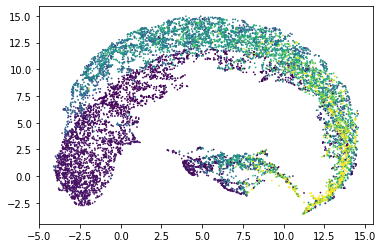

In [50]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)

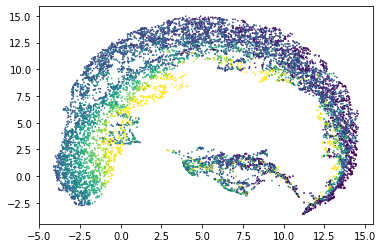

In [21]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch11"], s=0.5, cmap="viridis", norm=norm)

In [28]:
correlation = df.loc[selector].corr()

In [42]:
correlation["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_Intensity_MC_Ch7                      0.844492
feat_Intensity_MC_BF2                      0.812196
feat_Intensity_MC_Ch03                     0.786532
feat_Mean Pixel_M07_Ch7                    0.769172
feat_Max Pixel_MC_Ch7                      0.748033
feat_Area_M03                              0.737796
feat_Median Pixel_M07_Ch7                  0.715626
feat_Mean Pixel_M09_BF2                    0.681302
feat_Bright Detail Intensity R3_MC_Ch03    0.677381
feat_Width_M03                             0.669174
feat_Bright Detail Intensity R3_MC_Ch7     0.664806
feat_Area_M07                              0.657513
feat_Intensity_MC_Ch04                     0.627018
feat_Length_M03                            0.626446
feat_Height_M03                            0.625891
feat_Length_M04                            0.619570
feat_Height_M04                            0.619368
feat_Width_M04                             0.607599
feat_Width_M

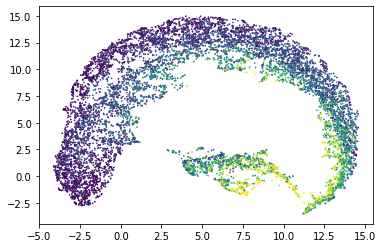

In [52]:
feat = "feat_Area_M01"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

In [39]:
correlation["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                     1.000000
feat_Bright Detail Intensity R3_MC_BF2    0.443835
feat_Bright Detail Intensity R3_MC_SSC    0.424507
feat_Aspect Ratio_M04                     0.420404
feat_Gradient RMS_M03_Ch03                0.419790
feat_Intensity_MC_SSC                     0.419393
feat_Mean Pixel_M06_SSC                   0.415596
feat_Median Pixel_M06_SSC                 0.413392
feat_Gradient RMS_M04_Ch04                0.411980
feat_Max Pixel_MC_SSC                     0.406212
feat_Modulation_M04_Ch04                  0.395514
feat_Area_M01                             0.385426
feat_Aspect Ratio Intensity_M04_Ch04      0.385120
feat_Bright Detail Intensity R3_MC_BF     0.377786
feat_Area_M09                             0.374136
feat_Contrast_M04_Ch04                    0.374121
meta_label_MCP_NEG_PSBA_POS               0.366163
feat_Modulation_M09_BF2                   0.355546
feat_Area_MC                              0.350077
feat_Length_M01                

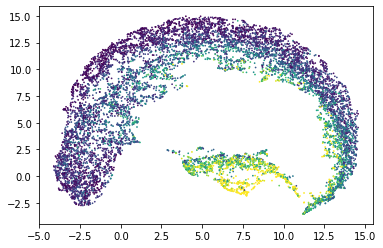

In [43]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.05), vmax=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"], s=0.5, cmap="viridis", norm=norm)

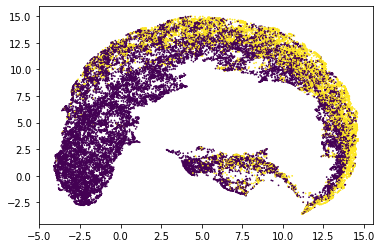

In [33]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_POS_PSBA_NEG"].astype(float), s=0.5)

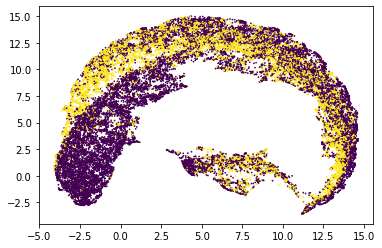

In [34]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_POS_PSBA_POS"].astype(float), s=0.5)

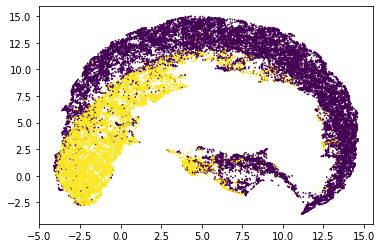

In [35]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_NEG_PSBA_POS"].astype(float), s=0.5)

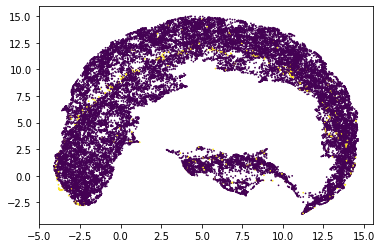

In [44]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_NEG_PSBA_NEG"].astype(float), s=0.5)

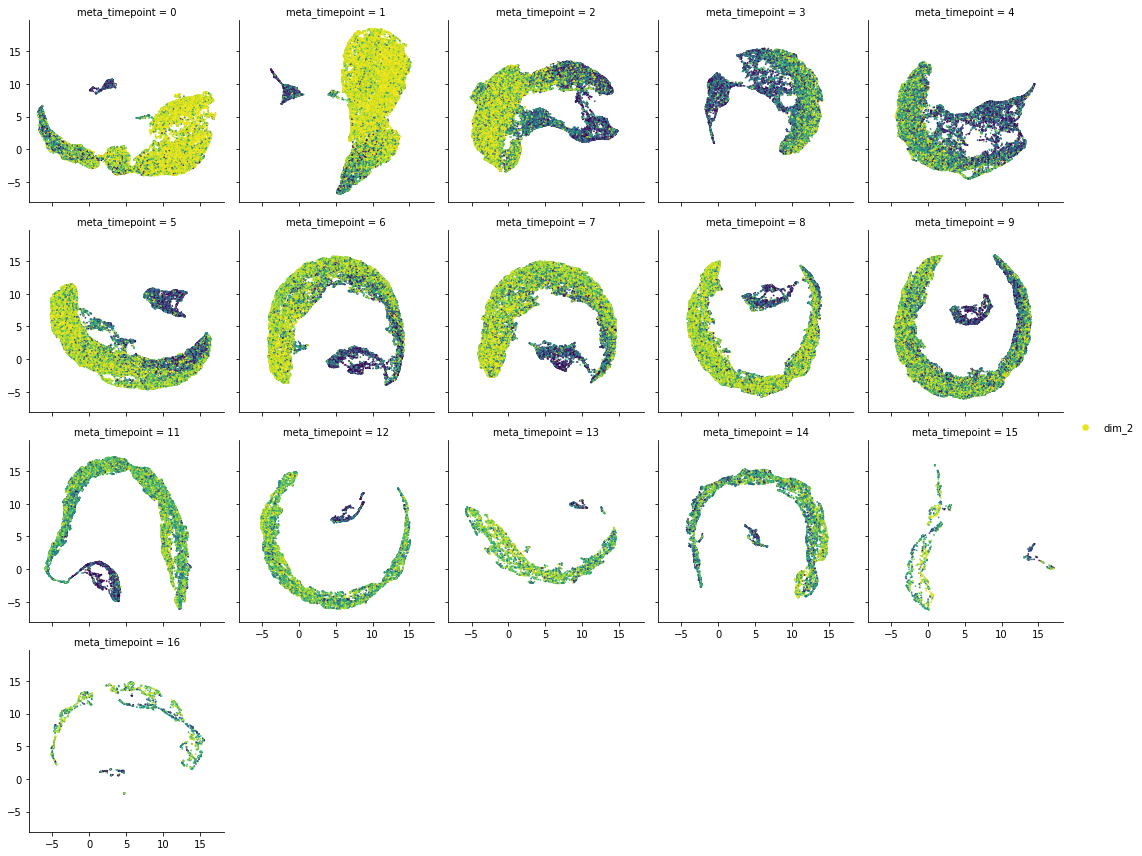

In [55]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_Aspect Ratio_M01"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, 
                x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")

## Inspect 1D projection

In [26]:
projected = load("data/umap/HTR_High_COI_pertp_1d.dat")

In [27]:
df = data[data["meta_group"] == "High"].set_index("meta_id").join(projected.set_index("meta_id"))

In [29]:
selector = (df["meta_timepoint"]=="T7") & (df["meta_replicate"]=="R1")

In [32]:
correlation = df.loc[selector].corr()
correlation["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_Intensity_MC_Ch7                      0.860506
feat_Intensity_MC_BF2                      0.857624
feat_Intensity_MC_Ch03                     0.805190
feat_Area_M03                              0.772304
feat_Mean Pixel_M07_Ch7                    0.729096
feat_Bright Detail Intensity R3_MC_Ch03    0.723121
feat_Area_M07                              0.711101
feat_Max Pixel_MC_Ch7                      0.706987
feat_Median Pixel_M07_Ch7                  0.696666
feat_Width_M03                             0.691072
feat_Mean Pixel_M09_BF2                    0.666908
feat_Length_M03                            0.660140
feat_Height_M03                            0.659656
feat_Length_M04                            0.659121
feat_Height_M04                            0.658964
feat_Width_M07                             0.650215
feat_Bright Detail Intensity R3_MC_Ch7     0.648253
feat_Width_M04                             0.638950
feat_Intensi

<AxesSubplot:xlabel='dim_1', ylabel='feat_Intensity_MC_Ch04'>

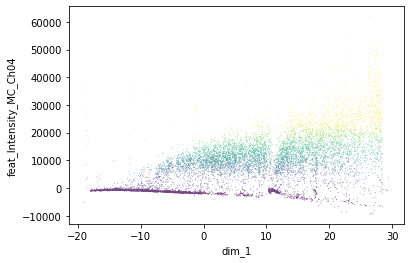

In [37]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.95))
seaborn.scatterplot(data=df.loc[selector], x="dim_1", y="feat_Intensity_MC_Ch04", c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)
# plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)

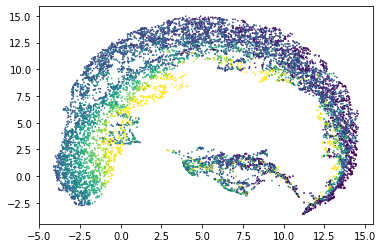

In [21]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch11"], s=0.5, cmap="viridis", norm=norm)

In [28]:
correlation = df.loc[selector].corr()

In [42]:
correlation["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_Intensity_MC_Ch7                      0.844492
feat_Intensity_MC_BF2                      0.812196
feat_Intensity_MC_Ch03                     0.786532
feat_Mean Pixel_M07_Ch7                    0.769172
feat_Max Pixel_MC_Ch7                      0.748033
feat_Area_M03                              0.737796
feat_Median Pixel_M07_Ch7                  0.715626
feat_Mean Pixel_M09_BF2                    0.681302
feat_Bright Detail Intensity R3_MC_Ch03    0.677381
feat_Width_M03                             0.669174
feat_Bright Detail Intensity R3_MC_Ch7     0.664806
feat_Area_M07                              0.657513
feat_Intensity_MC_Ch04                     0.627018
feat_Length_M03                            0.626446
feat_Height_M03                            0.625891
feat_Length_M04                            0.619570
feat_Height_M04                            0.619368
feat_Width_M04                             0.607599
feat_Width_M

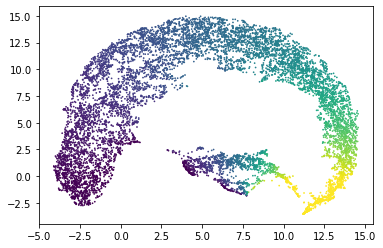

In [41]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch7"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch7"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch7"], s=0.5, cmap="viridis", norm=norm)

In [39]:
correlation["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                     1.000000
feat_Bright Detail Intensity R3_MC_BF2    0.443835
feat_Bright Detail Intensity R3_MC_SSC    0.424507
feat_Aspect Ratio_M04                     0.420404
feat_Gradient RMS_M03_Ch03                0.419790
feat_Intensity_MC_SSC                     0.419393
feat_Mean Pixel_M06_SSC                   0.415596
feat_Median Pixel_M06_SSC                 0.413392
feat_Gradient RMS_M04_Ch04                0.411980
feat_Max Pixel_MC_SSC                     0.406212
feat_Modulation_M04_Ch04                  0.395514
feat_Area_M01                             0.385426
feat_Aspect Ratio Intensity_M04_Ch04      0.385120
feat_Bright Detail Intensity R3_MC_BF     0.377786
feat_Area_M09                             0.374136
feat_Contrast_M04_Ch04                    0.374121
meta_label_MCP_NEG_PSBA_POS               0.366163
feat_Modulation_M09_BF2                   0.355546
feat_Area_MC                              0.350077
feat_Length_M01                

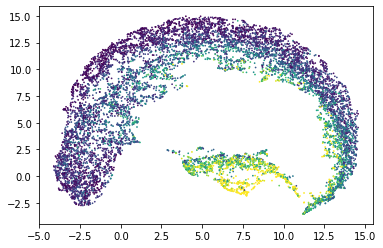

In [43]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.05), vmax=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"], s=0.5, cmap="viridis", norm=norm)

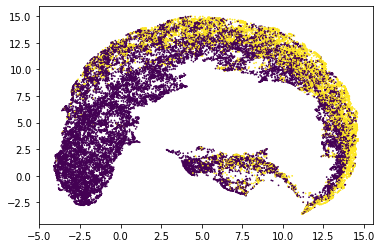

In [33]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_POS_PSBA_NEG"].astype(float), s=0.5)

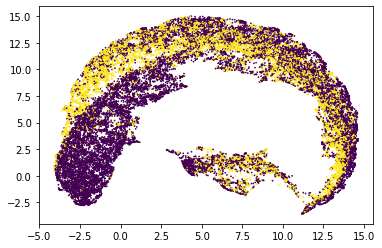

In [34]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_POS_PSBA_POS"].astype(float), s=0.5)

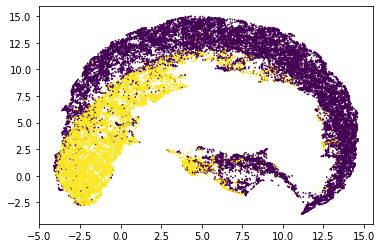

In [35]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_NEG_PSBA_POS"].astype(float), s=0.5)

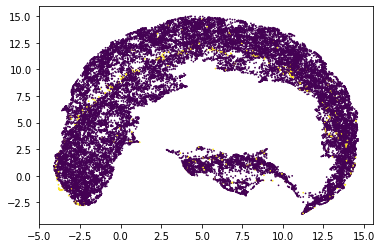

In [44]:
tmp = df[df["meta_timepoint"]=="T7"]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]=="T7"]["meta_label_MCP_NEG_PSBA_NEG"].astype(float), s=0.5)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

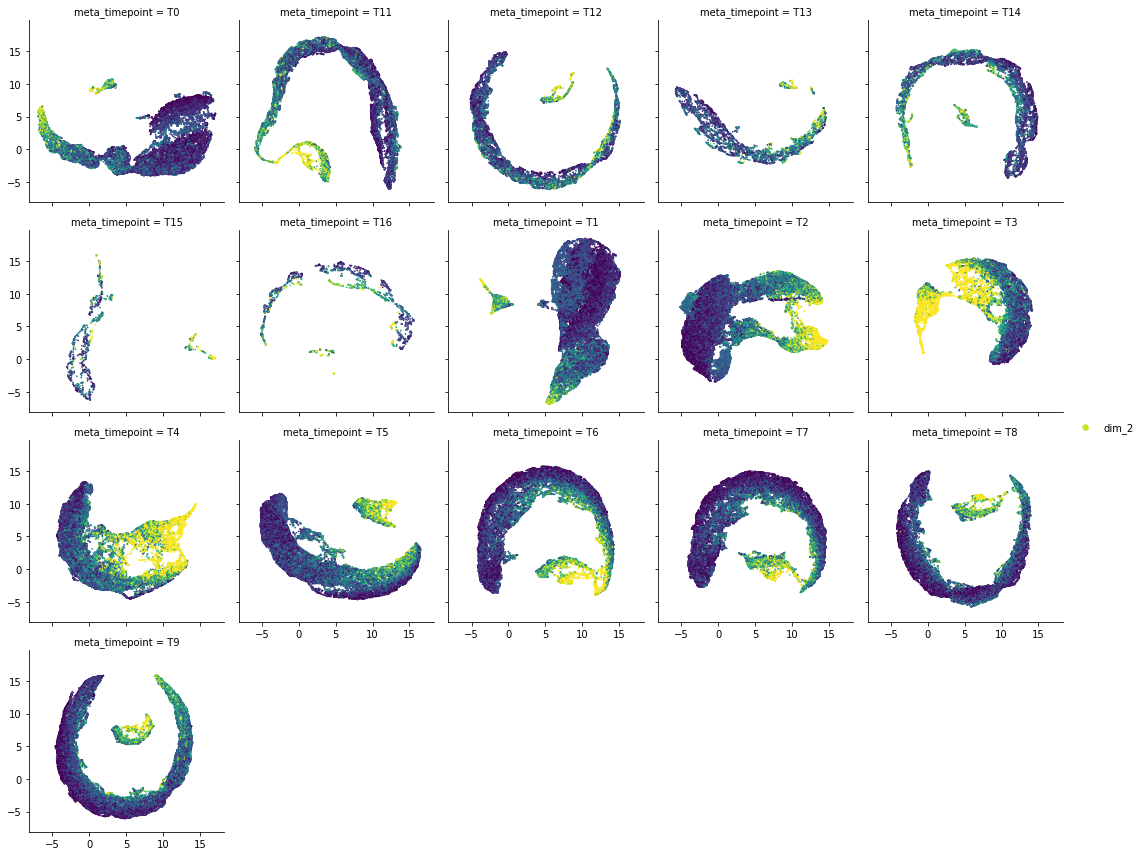

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [47]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.05), vmax=df.loc[selector, "feat_Bright Detail Intensity R3_MC_BF2"].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, 
                x="dim_1", y="dim_2", c="feat_Bright Detail Intensity R3_MC_BF2", s=0.5, cmap="viridis", norm=norm)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")